## Preprocessing 

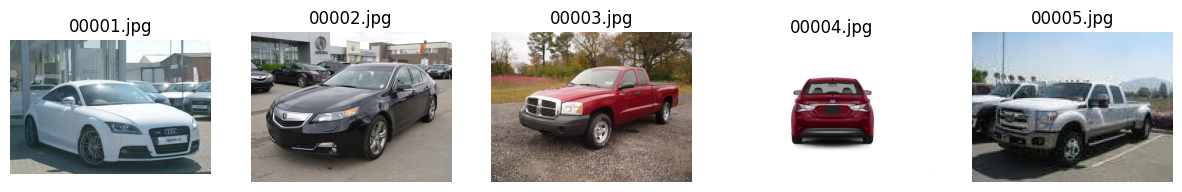

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image



# Set dataset path (update this based on your system)
DATASET_PATH = "cars_dataset/cars_train/cars_train"  # Change to actual path

# List all images
image_files = [f for f in os.listdir(DATASET_PATH) if f.endswith(".jpg")]

# Display some images
def show_sample_images(image_files, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        img_path = os.path.join(DATASET_PATH, image_files[i])
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(image_files[i])
    plt.show()

# Show random images
show_sample_images(image_files)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8610327..2.64].


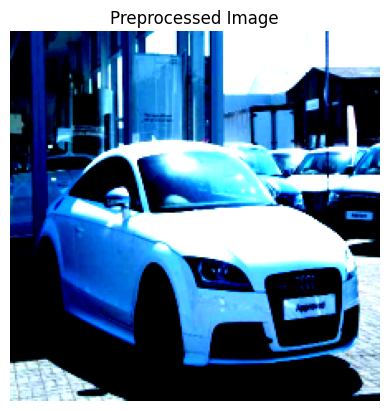

In [2]:
import torchvision.transforms as transforms

# Define preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Apply transformation to a sample image
img_path = os.path.join(DATASET_PATH, image_files[0])
img = Image.open(img_path)

# Transform and show
transformed_img = transform(img)
plt.imshow(transformed_img.permute(1, 2, 0))  # Convert from tensor format
plt.axis("off")
plt.title("Preprocessed Image")
plt.show()


In [3]:
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

# Custom dataset class
class CarDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(".jpg")]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, self.image_files[idx]  # Return image & filename

# Create dataset & DataLoader
car_dataset = CarDataset(DATASET_PATH, transform=transform)
car_dataloader = DataLoader(car_dataset, batch_size=16, shuffle=True, num_workers=0)

# Check batch size
batch = next(iter(car_dataloader))
print(f"Batch shape: {batch[0].shape}")  # Should be (batch_size, 3, 224, 224)


Batch shape: torch.Size([16, 3, 224, 224])


## ResNet50

In [4]:
import torch
import torchvision.models as models
import torch.nn as nn

# Load pre-trained ResNet50 model
resnet = models.resnet50(pretrained=True)

# Remove the final classification layer (FC layer)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])

# Set model to evaluation mode (important for inference)
resnet.eval()

# Move to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# resnet.to(device)

print(resnet)  # Print model architecture


C:\Users\User\anaconda3\envs\car-search\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\car-search\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [5]:
import torchvision.transforms as transforms
from PIL import Image
import torch

# Define image preprocessing pipeline (must match training preprocessing)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

def extract_features(img_path, model, device):
    """ Extracts the feature vector from an image using ResNet50. """
    # Load image
    image = Image.open(img_path).convert("RGB")
    
    # Apply preprocessing
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Move image to the same device as the model
    image = image.to(device)

    # Extract features
    with torch.no_grad():  # Disable gradients for inference
        features = model(image)

    # Flatten the features into a 1D vector
    features = features.view(features.shape[0], -1)

    return features.cpu().numpy()  # Convert to NumPy array


In [6]:
# Choose a sample image from the dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sample_img = "cars_dataset/cars_train/cars_train/00001.jpg"  # Change to actual path

# Extract features
embedding = extract_features(sample_img, resnet, device)

# Print feature vector shape
print(f"Feature vector shape: {embedding.shape}")


Feature vector shape: (1, 2048)


In [7]:
# print(embedding)

## Extract feautures from all images 

In [8]:
# #check if embeddings already exists 

# import os
# import numpy as np

# # Check if embeddings exist
# if os.path.exists("car_embeddings.npy") and os.path.exists("car_filenames.npy"):
#     print("Loading precomputed embeddings...")
#     embeddings = np.load("car_embeddings.npy") 
#     file_names = np.load("car_filenames.npy")
# else:
#     print("Extracting features (first-time only)...")
#     # Run the feature extraction loop (as we did before)


In [9]:
# import numpy as np
# from tqdm import tqdm  # Progress bar

# # Define where to store embeddings
# image_paths = [os.path.join(DATASET_PATH, f) for f in os.listdir(DATASET_PATH) if f.endswith(".jpg")]
# embeddings = []
# file_names = []

# # Process images in batches
# for img_path in tqdm(image_paths, desc="Extracting Features"):
#     feature_vector = extract_features(img_path, resnet, device)  # Get embedding
#     embeddings.append(feature_vector)  # Store feature vector
#     file_names.append(img_path)  # Store image path

# # Convert to NumPy array
# embeddings = np.vstack(embeddings)  # Stack into (num_images, 2048) shape

# # Save embeddings and file names
# np.save("car_embeddings.npy", embeddings)  # Save embeddings
# np.save("car_filenames.npy", np.array(file_names))  # Save file paths

# print(f"Embeddings saved! Shape: {embeddings.shape}")


In [10]:
import numpy as np  # Ensure numpy is imported

# Load saved embeddings and filenames
embeddings = np.load("car_embeddings.npy")  # Load precomputed embeddings
file_names = np.load("car_filenames.npy")

print(f"Loaded {embeddings.shape[0]} embeddings, each of size {embeddings.shape[1]}")



Loaded 8144 embeddings, each of size 2048


## Implement FAISS for Similarity Search

In [11]:
import gc
import torch

gc.collect()  # Clean up Python memory
torch.cuda.empty_cache()  # Clear GPU memory (if using CUDA)


In [12]:
import psutil

mem = psutil.virtual_memory()
print(f"Total RAM: {mem.total / 1e9:.2f} GB")
print(f"Available RAM: {mem.available / 1e9:.2f} GB")
print(f"RAM Used: {mem.percent}%")



Total RAM: 7.96 GB
Available RAM: 1.38 GB
RAM Used: 82.7%


In [ ]:
import faiss
import numpy as np


# Load saved embeddings
embeddings = np.load("car_embeddings.npy").astype("float32")  # FAISS requires float32
file_names = np.load("car_filenames.npy")

# Create FAISS index


index = faiss.IndexIVFFlat(faiss.IndexFlatL2(embeddings.shape[1]), embeddings.shape[1], 40)
index.train(embeddings[:100])  # Train on only 100 images
index.add(embeddings[:40])  # Add only 40 images


In [ ]:
faiss.write_index(index, "faiss_index_optimized.bin")
print("✅ FAISS index saved.")


In [ ]:
index = faiss.read_index("faiss_index_optimized.bin")
print("✅ FAISS index loaded from disk.")

In [ ]:
import psutil

mem = psutil.virtual_memory()
print(f"Before FAISS - Available RAM: {mem.available / 1e9:.2f} GB")

# Add embeddings here...

mem = psutil.virtual_memory()
print(f"After FAISS - Available RAM: {mem.available / 1e9:.2f} GB")


## Find similar images 

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

def search_similar_images(query_img_path, index, model, device, file_names, k=5):
    """
    Given a query image, finds k most similar images using FAISS.
    """
    # Extract feature vector for query image
    query_vector = extract_features(query_img_path, model, device)

    # Search in FAISS index
    distances, indices = index.search(query_vector, k)  # Find k nearest neighbors

    # Get the paths of similar images
    similar_images = [file_names[i] for i in indices[0]]

    # Display results
    fig, axes = plt.subplots(1, k+1, figsize=(15, 5))
    
    # Show query image
    query_img = Image.open(query_img_path)
    axes[0].imshow(query_img)
    axes[0].axis("off")
    axes[0].set_title("Query Image")

    # Show similar images
    for i in range(k):
        img = Image.open(similar_images[i])
        axes[i+1].imshow(img)
        axes[i+1].axis("off")
        axes[i+1].set_title(f"Match {i+1}")

    plt.show()

    return similar_images


## Test 

In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn

# ✅ Ensure device is set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Load pre-trained ResNet50 (feature extractor)
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # Remove FC layer
resnet.eval().to(device)

print("✅ ResNet50 loaded successfully!")


In [ ]:
# query_image = "audi.jpg"  # Change this to an actual test image

# # Find similar images
# similar_images = search_similar_images(query_image, index, resnet , device, file_names, k=5)
